# Cointegration for Pairs Trading


We have seen in the previous notebooks, that one can identify similar stocks using correlation (and most probably not purchase two similar stocks as both could drop at the same time).

Now, once we have identified two stocks that are correlated (similar), one can also think of utilizing this insight for trading; as in buy the similar stocks,... confusing, right?! Well, using a proper techinque it can make sense actually. 

This technique is called **pairs trading** and I stumbled upon it attending in a lecture related to AI for Trading. Since it seemed interesting (and simple enough to implement), this notebook covers some code snippets related to identifying two suitable stocks for pair trading. The comparison is a visual one (and not as detailed as a cointegration test using a statistical library!).

## What is Pairs Trading?

The idea is quite simple: choose two similar stocks, and expect both stocks to have similar values over time even if they diverge for a short period. In other words: if one stock would diverge from the other, you can expect this deviation to be temporary and the strategy here is: the stock that goes up, you should consider selling soon, and the one going down, you should consider buying more. In the image below, you would consider selling the red ticker at the highest point of the deviation and buying more from the blue ticker at the same time.


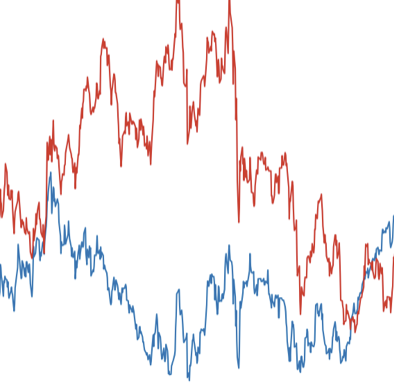


For this idea correlation metrics (as Pearson's) are unfortunately not enough and we would need to use a more compex identifier (not too complex fortunately).

## What is Cointegration?

Let's first recap correlation. In case of two signals, signal_a and signal_b, the correlation simply indicates how likely signal_a increases or decreases in case signal_b shows an increase or decrease. It does not show the magnitude of the increase or decrease. A pair of correlated stocks could therefore diverge significantly over time while being highly correlated.

**Cointegration** on the other hand, is a more detailed indicator for the similarity of signals than correlation. It would indicate the magnitude of the signals changes (over time in the case below). 

**Keep the following major question in mind: how good can one signal be expressed as a simple linear combination of the other?**

Note, that cointegrated signals do not necessary have to be correlated on shorter periods of observation


## How to Measure Cointegration?

An interesting approach is the "Two-Step Engle-Granger Test" that is defined as

* get something called a **hedge ratio** from two signals and
* caculate a **spread** from it.

If the calculated **spread** is **stationary**, two signals are cointegrated. 

Sounds rather complicated, right?! Well, actually its a very simple procedure. Let's dive into it.

In [1]:
from helper import helpers # reuse the useful code snippets from the simple_stock_comparison notebook

# first we need to get two stocks
# I will choose some Airline related stocks 
# Lufthansa
ticker_1 = helpers.fetch_ticker("LHA.DE")
ticker_1_hist = helpers.fetch_ticker_hist(ticker_1, "10y")
# Frankfurt Airport
ticker_2 = helpers.fetch_ticker("FRA.DE")
ticker_2_hist = helpers.fetch_ticker_hist(ticker_2, "10y")

### Lets visualize our signals

Since both have different value ranges, we can plot them on different axes.

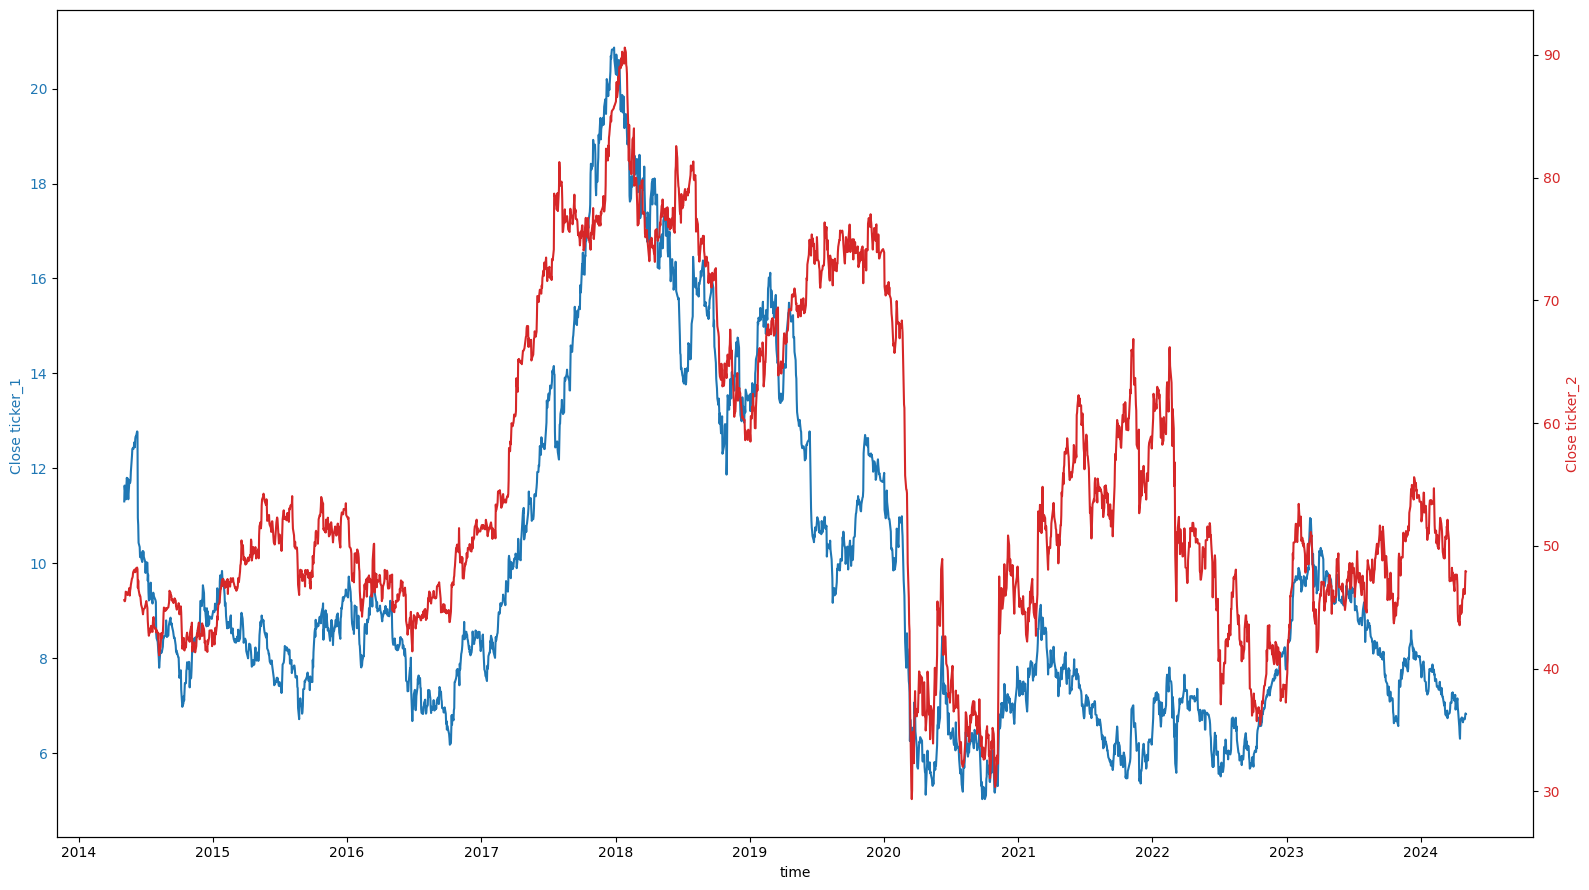

In [2]:
helpers.plot_at_once(ticker_1_hist, ticker_2_hist)

The major observation is that the stocks do look very similar. The correlations coefficient adds to this assumption.

In [3]:
helpers.calc_corr_coeff(ticker_1_hist['Close'],ticker_2_hist['Close'])

0.8180917932508617

### Preprocess the signals

Although the data in our plot seems to be aligned (due to the usage of two different axes), we would need to bring the singals on the same scale in order to avoid any invariances (in other words, lets compare apples with apples).

For this, we would divide each item in the signals by their first value. Simple.


In [4]:
ticker_1_hist["Close_normalized"] = ticker_1_hist['Close'] / ticker_1_hist['Close'][0]
ticker_2_hist["Close_normalized"] = ticker_2_hist['Close'] / ticker_2_hist['Close'][0]

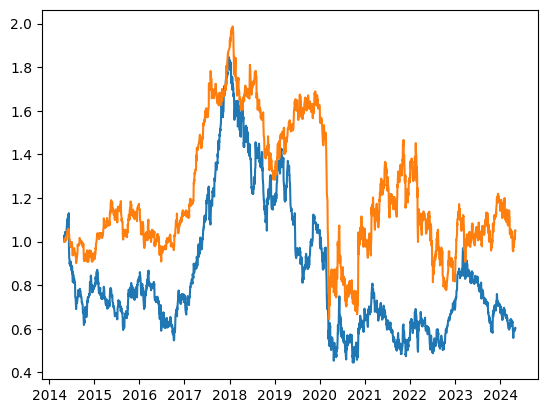

In [5]:
from matplotlib import pyplot as plt
# now we can plot signals on the same axis
plt.plot(ticker_1_hist["Close_normalized"])
plt.plot(ticker_2_hist["Close_normalized"])

### Create a Linear Regression Line

We will use numpy's poly1d function for this.

**Again, lets cap the idea: how good can one signal be expressed as a simple linear combination of the other?**

We can perform a linear regression from the two signals. Unlike in most examples, where the linear regression is performed on the x-axis, here the linear regression is carried out on the TWO signals.

=> we want to draw a straight line representing the two functions (the line is basically placed between the signals). The result are two coefficients: the slope $m$ and the bias $b$. And with these we can see if one signal is a good linear combination of the other.


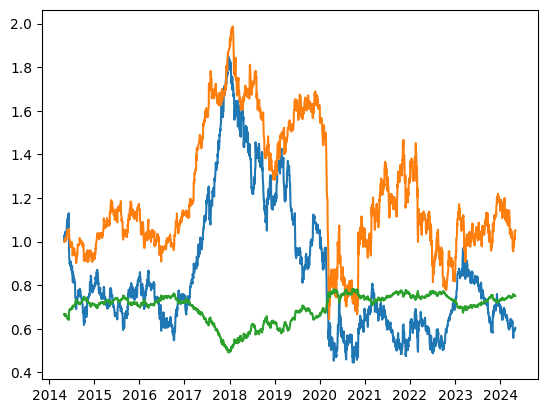

In [6]:
import numpy as np
# create a line between the 
coeffs = np.poly1d(np.polyfit(ticker_2_hist["Close_normalized"], ticker_1_hist["Close_normalized"], 1))
# express one stock as a linear combination of the other 
ticker_2_hist["Close_regression"] = coeffs[0] * ticker_1_hist["Close_normalized"] + coeffs[1]
plt.plot(ticker_1_hist["Close_normalized"])
plt.plot(ticker_2_hist["Close_normalized"])
plt.plot(ticker_2_hist["Close_regression"])

=> We can see the values of the stock along with a linear regression line.

We are, however, more interested in the coefficients of the line: the $m$ and $b$ value, where $m$ is the **hedge ratio**

In [7]:
coeffs

poly1d([ 0.87596773, -0.20817901])

And using this, we can calculate the **spread** mentioned above as
```{math}
spread = hist_2_normalized - (m * hist_1_normalized + b)
```

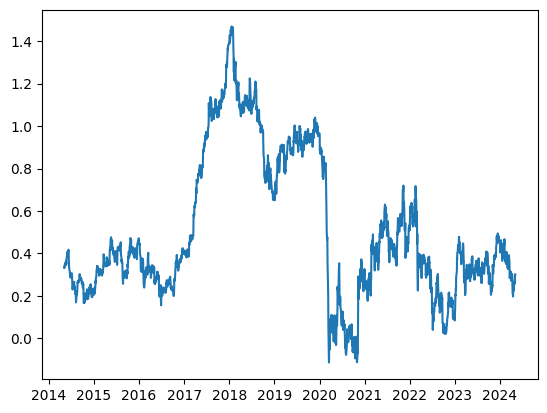

In [8]:
spread = ticker_2_hist["Close_normalized"] - ticker_2_hist["Close_regression"]
plt.plot(spread)

## What does the plot show us?

A spread around 0 represents a high cointegration and 1 the opposite. We can see that in our plot, the spread is likely not around 0. In other words: its not stationary!

In order to get a reasonable (non-visual) value, however, we would need to check for the p-value (representing the tail of a Gaussian distribution). One way is to use the Dickey-Fuller test (which I will skip here as this was meant as a visual interpretation of the cointegration).

Now, this goes all a little faster and more precise using an actual implementation of the Engle-Granger Test from a statistics library.

In [9]:
from statsmodels.tsa.stattools import coint

coint_t, p_val, critical, = coint(ticker_2_hist["Close_normalized"], ticker_1_hist["Close_normalized"])
print(p_val)

0.04240681071406483


=> the smaller the p-value, the more cointegrated the signals are. In this case the value is not small enough unfortunately. 